# New peepholes!

In [1]:
import os
import torch
import numpy as np
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

In [2]:
import matplotlib.pyplot as plt

In [3]:
# python stuff
from pathlib import Path as Path
from numpy.random import randint

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from peepholes.peepholes import Peepholes
from peepholes.svd_peepholes import peep_matrices_from_svds as parser_fn

# torch stuff
import torch
from torchvision.models import vgg16, VGG16_Weights

In [11]:
import pickle
#import datetime
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [13]:
from clustering.clustering import *

In [4]:
# TODO: cambiare i path (anche nei moduli)
p_dir = os.path.join('../data/peepholes')
svd_dir = os.path.join('../data/svds')

## Load SVD 

In [5]:
file_path = os.path.join(svd_dir, 'svds')
svds = TensorDict.load_memmap(file_path)

### Singular Values visualization

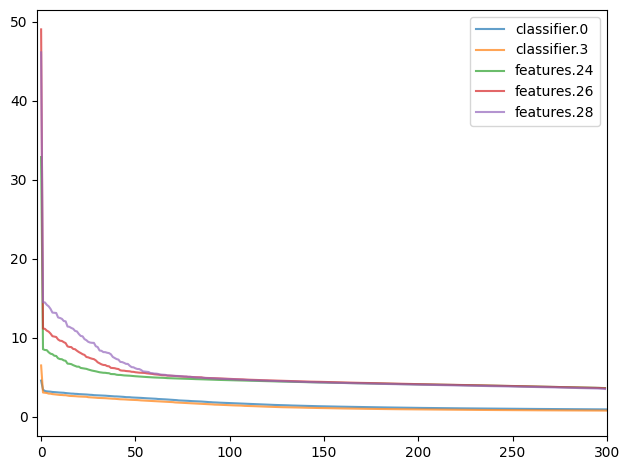

In [6]:
fig, axs = plt.subplots()
for i, layer in enumerate(svds.keys()):
    axs.plot(svds[layer]['s'], label=layer, alpha=0.7)
axs.set_xlim(-2, 300)
axs.legend()
plt.tight_layout()

## Load dataset

In [6]:
#--------------------------------
# Dataset 
#--------------------------------
# model parameters
dataset = 'CIFAR100' 
seed = 29
bs = 64

ds = Cifar(dataset=dataset)

ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f16d59cc9e0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f16d6a25190>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f16d31ad3a0>}

## Load model

In [9]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:6 device


In [10]:
pretrained = True
model_dir = '/srv/newpenny/XAI/LM/models'
model_name = f'vgg16_pretrained={pretrained}_dataset={dataset}-'\
f'augmented_policy=CIFAR10_bs={bs}_seed={seed}.pth'


nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)

/home/liviamanovi/gitty/XAI/src/models/model_wrap.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)



-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

train_loss 1.4151224618911744
val_loss 0.8791644280883157
train_accuracy 62.295
val_accuracy 74.96000000000001
epoch 59
batch_size 64
lr 0.001
-----------------



## Load peepholes

In [7]:
abs_path = '/srv/newpenny/XAI/generated_data'

In [8]:
phs_name = 'peepholes'
phs_dir = os.path.join(abs_path, 'peepholes')
peepholes = Peepholes(
        path = phs_dir,
        name = phs_name,
        )
loaders = ds.get_dataset_loaders()


In [9]:
# copy dataset to peepholes dataset
peepholes.get_peep_dataset(
        loaders = loaders,
        verbose = True
        ) 


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.test exists. Loading from disk.
loaded n_samples:  10000


In [10]:
ph_dl = peepholes.get_dataloaders(batch_size=128, verbose=True)

creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test


In [14]:
layers_dict = {'classifier': [0, 3],
               'features': [24, 26, 28]}
model.set_target_layers(target_layers=layers_dict, verbose=True)
print('target layers: ', model.get_target_layers().keys()) 

target layers:  dict_keys(['classifier.0', 'classifier.3', 'features.24', 'features.26', 'features.28'])


In [15]:
layers_list = list(model.get_target_layers().keys())

In [15]:
available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())
#list(next(iter(ph_dl['train']))['peepholes'].keys())

## Clustering class

* fit on training data
    * can obtain k from the data shape 
* the Class can provide up to the output_peephole per layer. then we will use dedicated functions to get:
    * quantities per single layer (max, entropy)
    * combined scores with multiple layers (simple weights and exponentials)

In [60]:
clust_kwargs = {}

layer = 'classifier-3'

clust_kwargs[layer]= {'algorithm': 'kmeans',
                      'k': 100,
                      'n': num_classes,
                       }


In [24]:
class Clustering: # quella buona
    def __init__(self, algorithm, k, n_clusters, seed=42, 
                 base_dir='clustering'):
        self.algorithm = algorithm  
        self.k = k  
        self.n_clusters = n_clusters
        self.seed = seed
        self.base_dir = f'/srv/newpenny/XAI/generated_data/{base_dir}'

        self._fitted_model = None
        self._cluster_assignments = None        # cluster assignments from the model
        self._cluster_centers = None            # cluster centers from the model
        self._cluster_covariances = None        # cluster covariances from the model
        self._empirical_posteriors = None       # empirical posteriors (P(g, c))

    def fit(self, core_vectors, labels=None):
        '''
        Perform clustering on the training core_vectors of a specific layer.
        
        Args:
        - core_vectors (Tensor): Ex-"peepholes" with reduced dimension (n_samples, k)
        - labels (Tensor): Labels for empirical posteriors computation (optional)
        '''
        #if self.algorithm == 'gmm':
        #    model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
        #    model.fit(core_vectors)
        #    self._cluster_assignments = model.predict(core_vectors)
        #    self._cluster_centers = model.means_
        #    self._cluster_covariances = model.covariances_
        #    self._fitted_model = model
        #    
        #elif self.algorithm == 'kmeans':
        #    model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
        #    model.fit(core_vectors)
        #    self._cluster_assignments = model.predict(core_vectors)
        #    self._cluster_centers = model.cluster_centers_
        #    self._fitted_model = model
#
        ## compute empirical posteriors if labels are provided
        #if labels is not None:
        #    self.compute_empirical_posteriors(labels)
        if self.algorithm == 'gmm':
            model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.means_
            self._cluster_covariances = model.covariances_
            self._fitted_model = model
    
        elif self.algorithm == 'kmeans':
            model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.cluster_centers_
            self._fitted_model = model
    
        # Check if clustering was successful
        if self._cluster_assignments is None:
            raise ValueError("Clustering failed. No assignments were generated.")
    
        # Compute empirical posteriors if labels are provided
        if labels is not None:
            self.compute_empirical_posteriors(labels)

    def compute_empirical_posteriors(self, labels):
        '''
        Compute the empirical posterior matrix P, where P(g, c) is the probability
        that a sample assigned to cluster g belongs to class c.

        Args:
        - labels (Tensor): True class labels for the samples (n_samples, )
        '''
        n_samples = len(labels)
        n_classes = len(torch.unique(labels))
        
        # initialize matrix to count occurrences of (cluster g, class c) pairs
        P_counts = torch.zeros(self.n_clusters, n_classes)

        # count occurrences of (cluster g, class c) pairs
        for i in range(n_samples):
            c = int(labels[i].item())  # true class label
            g = int(self._cluster_assignments[i])  # cluster assignment
            P_counts[g, c] += 1

        # normalize to get empirical posteriors
        P_empirical = P_counts / P_counts.sum(dim=1, keepdim=True)

        # nandle potential division by zero
        P_empirical = torch.nan_to_num(P_empirical)  # replace NaN with 0

        self._empirical_posteriors = P_empirical

    def cluster_probabilities(self, core_vectors):
        '''
        Get cluster probabilities for the provided core_vectors based on the fitted model.
        
        Args:
        - core_vectors (Tensor): Peepholes with reduced dimension (n_samples, k)
        
        Returns:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        '''
        if self.algorithm == 'gmm':
            return self._fitted_model.predict_proba(core_vectors)  # (n_samples, n_clusters)
        elif self.algorithm == 'kmeans':
            # get distances to each cluster center
            distances = self._fitted_model.transform(core_vectors)
            distances = torch.tensor(distances)
            # convert distances to probabilities (soft assignment)
            cluster_probs = torch.exp(-distances ** 2 / (2 * (distances.std() ** 2)))  # Gaussian-like softmax
            cluster_probs = cluster_probs / cluster_probs.sum(dim=1, keepdim=True)  # normalize to probabilities
            return cluster_probs

    def map_clusters_to_classes(self, core_vectors):
        '''
        Map the cluster probabilities to class probabilities using empirical posteriors.
        
        Args:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        
        Returns:
        - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
        '''
        if self._empirical_posteriors is None:
            raise RuntimeError('Please run compute_empirical_posteriors() first.')

        cluster_probs = self.cluster_probabilities(core_vectors)
        cluster_probs = torch.tensor(cluster_probs, dtype=torch.float32)
        
        class_probs = torch.matmul(cluster_probs, self._empirical_posteriors)  # shape: (n_samples, n_classes)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True) # aka the new peepholes
        return class_probs

    # confidence scores ---------------------
    #def get_confidence_scores(self, class_probs, score_type="max"):
    #    '''
    #    Compute confidence scores (either max or entropy), save them, or load if they already exist.
    #    
    #    Args:
    #    - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
    #    - score_type (str): Either 'max' or 'entropy' to specify the type of confidence score.
    #    
    #    Returns:
    #    - confidence_scores (Tensor): The computed confidence scores (n_samples, )
    #    '''
    #    confidence_dir = os.path.join(self.base_dir, 'confidence_scores')
    #    filepath = self.construct_filepath(prefix=f"cs={score_type}", suffix="pkl", dir_path=confidence_dir)
    #    
    #    if os.path.exists(filepath):
    #        print(f"Confidence scores ({score_type}) already exist at {filepath}. Loading...")
    #        with open(filepath, 'rb') as f:
    #            confidence_scores = pickle.load(f)
    #        return confidence_scores
    #
    #    if score_type == "max":
    #        confidence_scores = torch.max(class_probs, dim=1).values
    #    elif score_type == "entropy":
    #        # entropy: -sum(p * log(p)) across classes (axis 1)
    #        entropy = -torch.sum(class_probs * torch.log(class_probs + 1e-12), dim=1)
    #        confidence_scores = entropy
    #    else:
    #        raise ValueError(f"Invalid score_type: {score_type}. Use 'max' or 'entropy'.")
    #
    #    os.makedirs(confidence_dir, exist_ok=True)
    #    with open(filepath, 'wb') as f:
    #        pickle.dump(confidence_scores, f)
    #    print(f'Confidence scores ({score_type}) saved to {filepath}')
    #
    #    return confidence_scores
    def get_confidence_scores(self, class_probs, split='train', score_type='max', save=False):
        #confidence_dir = os.path.join(self.base_dir, 'confidence_scores')
        #os.makedirs(confidence_dir, exist_ok=True)
#
        #filename = "_".join([f'cs={score_type}', self.construct_filename()])
        #filepath = os.path.join(confidence_dir, split, filename)
#
        #if os.path.exists(filepath):
        #    print(f"Confidence scores ({score_type}) already exist at {filepath}. Loading...")
        #    with open(filepath, 'rb') as f:
        #        confidence_scores = pickle.load(f)
        #    return confidence_scores

        if score_type == "max":
            confidence_scores = torch.max(class_probs, dim=1).values
        elif score_type == "entropy":
            entropy = -torch.sum(class_probs * torch.log(class_probs + 1e-12), dim=1)
            confidence_scores = entropy
        else:
            raise ValueError(f"Invalid score_type: {score_type}. Use 'max' or 'entropy'.")
        #if save:
        #    with open(filepath, 'wb') as f:
        #        pickle.dump(confidence_scores, f)
        #    print(f'Confidence scores ({score_type}) saved to {filepath}')

        return confidence_scores



    # save/load results ---------------------
    def save_cluster_results(self, filepath=None):
        """
        Save the clustering results (assignments, centers, covariances) to a file.
        """
        if filepath is None:
            filepath = self.construct_filepath(suffix='pkl') 

        data = {
            'assignments': self._cluster_assignments,
            'centers': self._cluster_centers,
            'k': self.k,
        }

        if self.algorithm == 'gmm':
            data['covariances'] = self._cluster_covariances

        os.makedirs(os.path.dirname(filepath), exist_ok=True)

        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

        # print(f'Clustering results saved to {filepath}')

    def load_cluster_results(self, filepath=None):
        """
        Load clustering results from a file.
        """
        if filepath is None:
            filepath = self.construct_filepath(suffix='pkl') 

        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            self._cluster_assignments = results['assignments']
            self._cluster_centers = results['centers']
            self.k = results.get('k', self.k)

            if self.algorithm == 'gmm' and 'covariances' in results:
                self._cluster_covariances = results['covariances']

            print(f'Clustering results loaded from {filepath}')
        except FileNotFoundError:
            print(f"File {filepath} not found")
        except Exception as e:
            print(f"An error occurred while loading clustering results: {e}")

    def construct_filepath(self, suffix='pkl', **extra_kwargs):
        '''
        Constructs a file path for saving or loading clustering results based on attributes.
        Combines the base directory, attributes, and extra arguments into the file name.
        '''
 
        dir_path = self.base_dir
        os.makedirs(dir_path, exist_ok=True)
        filename = self.construct_filename(suffix=suffix, **extra_kwargs)
        return os.path.join(dir_path, filename)

    def construct_filename(self, suffix='pkl', **extra_kwargs):
        '''
        Constructs a detailed filename for saving clustering results,
        using class attributes and any extra keyword arguments passed.
        '''

        filename_kwargs = self.generate_kwargs_from_attrs()
        filename_kwargs.update(extra_kwargs)

        filename_parts = [f"{k}={v}" for k, v in filename_kwargs.items()]
        filename = "_".join(filename_parts) + f".{suffix}"
        
        return filename

    def generate_kwargs_from_attrs(self):
        '''
        Generate a dictionary of current class attributes and their values.
        This can be used for constructing filenames or passing arguments.
        '''
        attrs = {
            'algorithm': self.algorithm,
            'k': self.k,
            'n_clusters': self.n_clusters,
            'seed': self.seed
        }
        
        return attrs


In [25]:
class Clustering:
    def __init__(self, algorithm, k, n_clusters, seed=42, base_dir='clustering'):
        self.algorithm = algorithm  
        self.k = k  
        self.n_clusters = n_clusters
        self.seed = seed
        self.base_dir = f'../data/{base_dir}'

        self._fitted_model = None
        self._cluster_assignments = None        # cluster assignments from the model
        self._cluster_centers = None            # cluster centers from the model
        self._cluster_covariances = None        # cluster covariances from the model
        self._empirical_posteriors = None       # empirical posteriors (P(g, c))

    def fit(self, core_vectors, labels=None):
        '''
        Perform clustering on the core_vectors of a specific layer.
        
        Args:
        - core_vectors (Tensor): Ex-"peepholes" with reduced dimension (n_samples, k)
        - labels (Tensor): Labels for empirical posteriors computation (optional)
        '''
        if self.algorithm == 'gmm':
            model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.means_
            self._cluster_covariances = model.covariances_
            self._fitted_model = model
            
        elif self.algorithm == 'kmeans':
            model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.cluster_centers_
            self._fitted_model = model

        # compute empirical posteriors if labels are provided
        if labels is not None:
            self.compute_empirical_posteriors(labels)

    def compute_empirical_posteriors(self, labels):
        '''
        Compute the empirical posterior matrix P, where P(g, c) is the probability
        that a sample assigned to cluster g belongs to class c.

        Args:
        - labels (Tensor): True class labels for the samples (n_samples, )
        '''
        n_samples = len(labels)
        n_classes = len(torch.unique(labels))
        
        # initialize matrix to count occurrences of (cluster g, class c) pairs
        P_counts = torch.zeros(self.n_clusters, n_classes)

        # count occurrences of (cluster g, class c) pairs
        for i in range(n_samples):
            c = int(labels[i].item())  # true class label
            g = int(self._cluster_assignments[i])  # cluster assignment
            P_counts[g, c] += 1

        # normalize to get empirical posteriors
        P_empirical = P_counts / P_counts.sum(dim=1, keepdim=True)

        # nandle potential division by zero
        P_empirical = torch.nan_to_num(P_empirical)  # replace NaN with 0

        self._empirical_posteriors = P_empirical

    def cluster_probabilities(self, core_vectors):
        '''
        Get cluster probabilities for the provided core_vectors based on the fitted model.
        
        Args:
        - core_vectors (Tensor): Peepholes with reduced dimension (n_samples, k)
        
        Returns:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        '''
        if self.algorithm == 'gmm':
            return self._fitted_model.predict_proba(core_vectors)  # (n_samples, n_clusters)
        elif self.algorithm == 'kmeans':
            # get distances to each cluster center
            distances = self._fitted_model.transform(core_vectors)
            distances = torch.tensor(distances)
            # convert distances to probabilities (soft assignment)
            cluster_probs = torch.exp(-distances ** 2 / (2 * (distances.std() ** 2)))  # Gaussian-like softmax
            cluster_probs = cluster_probs / cluster_probs.sum(dim=1, keepdim=True)  # normalize to probabilities
            return cluster_probs

    def map_clusters_to_classes(self, core_vectors):
        '''
        Map the cluster probabilities to class probabilities using empirical posteriors.
        
        Args:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        
        Returns:
        - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
        '''
        if self._empirical_posteriors is None:
            raise RuntimeError('Please run compute_empirical_posteriors() first.')

        cluster_probs = self.cluster_probabilities(core_vectors)
        cluster_probs = torch.tensor(cluster_probs, dtype=torch.float32)
        
        class_probs = torch.matmul(cluster_probs, self._empirical_posteriors)  # shape: (n_samples, n_classes)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True) # aka the new peepholes
        return class_probs

    # save/load results ---------------------


In [113]:
algorithm = 'gmm'
k = 20
n_clusters = int(num_classes/2)

clustering = Clustering(algorithm, k, n_clusters)

In [129]:
# prepare data
core_vectors = {}
v_labels = {}
decisions = {}

for split in ['train', 'val', 'test']:
    first_batch = next(iter(ph_dl['train']))
    p = first_batch['peepholes']
    layer_keys = p.keys()  
    
    core_vectors[split] = {key: [] for key in layer_keys}
    v_labels[split] = []
    decisions[split] = []

    for batch in ph_dl[split]:
        
        peepholes = batch['peepholes']
        labels = batch['label']
        decision_results = batch['result']

        for layer, peephole_tensor in peepholes.items():
            batch_size, d = peephole_tensor.shape
                            
            reduced_peephole = peephole_tensor[:, :k]

            core_vectors[split][layer].append(reduced_peephole)
        v_labels[split].append(labels)
        decisions[split].append(decision_results.bool())
        
    for layer in core_vectors[split]:
        core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
    
    v_labels[split] = torch.cat(v_labels[split], dim=0)
    decisions[split] = torch.cat(decisions[split], dim=0)

In [34]:
vars(clustering)

{'algorithm': 'gmm',
 'k': 20,
 'n_clusters': 50,
 'seed': 42,
 'base_dir': '../data/clustering',
 '_fitted_model': None,
 '_cluster_assignments': None,
 '_cluster_centers': None,
 '_cluster_covariances': None,
 '_empirical_posteriors': None}

In [114]:
# fit clustering model
split = 'train'
layer = 'classifier.0'
labels = v_labels[split]

clustering.fit(core_vectors[split][layer], labels)

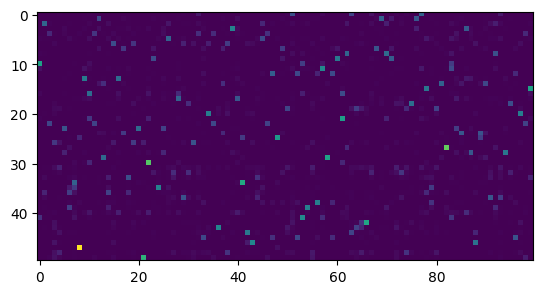

In [108]:
plt.imshow(clustering._empirical_posteriors)

In [125]:
max_scores = {}
entropy_scores = {}

for split in ['train', 'val']:
    class_probs = clustering.map_clusters_to_classes(core_vectors[split][layer])
    _max = clustering.get_confidence_scores(class_probs, split=split, score_type='max')
    _entropy = clustering.get_confidence_scores(class_probs, split=split, score_type='entropy')

    max_scores[split] = _max
    entropy_scores[split] = _entropy

Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...


### structure without tensordict

In [12]:
from tqdm import tqdm

In [143]:
k_list = [20]
n_clusters_list = [50]

# select algorithm
algorithm = 'gmm'

# loop over k and n_clusters
for k in k_list:
    # prepare data
    core_vectors = {}
    v_labels = {}
    decisions = {}
    print('Preparing data')
    for split in ['train', 'val']: #, 'test']:
        first_batch = next(iter(ph_dl['train']))
        p = first_batch['peepholes']
        layer_keys = p.keys() # so we can automatically loop over available layers 
        
        core_vectors[split] = {key: [] for key in layer_keys}
        v_labels[split] = []
        decisions[split] = []
    
        for batch in ph_dl[split]:
            
            peepholes = batch['peepholes']
            labels = batch['label']
            decision_results = batch['result']
    
            for layer, peephole_tensor in peepholes.items():
                batch_size, d = peephole_tensor.shape
                                
                reduced_peephole = peephole_tensor[:, :k]
    
                core_vectors[split][layer].append(reduced_peephole)
            v_labels[split].append(labels)
            decisions[split].append(decision_results.bool())
            
        for layer in core_vectors[split]:
            core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
        
        v_labels[split] = torch.cat(v_labels[split], dim=0)
        decisions[split] = torch.cat(decisions[split], dim=0)
    print('Data is ready')
    # clustering init and fit for each layer
    for n_clusters in tqdm(n_clusters_list):
        split = 'train'
        
        clustering = {}
        for layer in layer_keys:
            
            clustering[layer] = Clustering(algorithm, k, n_clusters)
            labels = v_labels[split]
            clustering[layer].fit(core_vectors[split][layer], labels)
    
        # use train split (get scores)
        max_scores = {}
        entropy_scores = {}
        split = 'train'
        class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])
        _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
        _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')
    
        max_scores[split] = _max
        entropy_scores[split] = _entropy
    
        # use val split
        split = 'val'
        class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])
        _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
        _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')
    
        max_scores[split] = _max
        entropy_scores[split] = _entropy

Preparing data
Data is ready


100%|████████████████████████████████████████████| 1/1 [02:11<00:00, 131.39s/it]

Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...


### structure with tensordict

Hopefully will look something like:
```python
all_scores = {
    20: {  # k value
        50: {  # n_clusters value
            'train': {
                'layer1': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                },
                'layer2': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                }
            },
            'val': {
                'layer1': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                },
                'layer2': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                }
            }
        }
    }
}


In [152]:
k_list = [20]
n_clusters_list = [50]

# select algorithm
algorithm = 'gmm'

# init results container
#all_scores = TensorDict()
all_scores = TensorDict({}, batch_size=[])

# loop over k and n_clusters
for k in k_list:
    all_scores.set(str(k), TensorDict({}, batch_size=[]))  # set for k
    # prepare data
    print('Preparing data')
    core_vectors = {}
    v_labels = {}
    decisions = {}

    for split in ['train', 'val']: #, 'test']:
        first_batch = next(iter(ph_dl['train']))
        p = first_batch['peepholes']
        layer_keys = p.keys() # so we can automatically loop over available layers 
        
        core_vectors[split] = {key: [] for key in layer_keys}
        v_labels[split] = []
        decisions[split] = []
    
        for batch in ph_dl[split]:
            
            peepholes = batch['peepholes']
            labels = batch['label']
            decision_results = batch['result']
    
            for layer, peephole_tensor in peepholes.items():
                batch_size, d = peephole_tensor.shape
                                
                reduced_peephole = peephole_tensor[:, :k]
    
                core_vectors[split][layer].append(reduced_peephole)
            v_labels[split].append(labels)
            decisions[split].append(decision_results.bool())
            
        for layer in core_vectors[split]:
            core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
        
        v_labels[split] = torch.cat(v_labels[split], dim=0)
        decisions[split] = torch.cat(decisions[split], dim=0)
    print('Data is ready')
    # clustering init and fit for each layer
    for n_clusters in tqdm(n_clusters_list):

        #all_scores[k] = {n_clusters: {}}
        all_scores[str(k)].set(str(n_clusters), TensorDict({
            'train': TensorDict({}, batch_size=[]),
            'val': TensorDict({}, batch_size=[])
        }, batch_size=[]))
        
        # fit clustering model for each layer on train split
        clustering = {}
        for layer in tqdm(layer_keys):
            clustering[layer] = Clustering(algorithm, k, n_clusters)
            labels = v_labels['train']  # Use the 'train' split labels
            clustering[layer].fit(core_vectors['train'][layer], labels)

        # compute max and entropy scores for both 'train' and 'val'
        for split in ['train', 'val']:
            all_scores[str(k)][str(n_clusters)][split] = {}
            for layer in layer_keys:
                class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])

                _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
                _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')

                all_scores[str(k)][str(n_clusters)][split][layer] = {
                    'max': _max,
                    'entropy': _entropy
                }
        

Preparing data
Data is ready


100%|████████████████████████████████████████████| 1/1 [02:08<00:00, 128.68s/it]


In [165]:
all_scores[str(k)][str(n_clusters)]['val']['classifier.0']['entropy']

tensor([3.5583, 3.0782, 1.9018,  ..., 1.8225, 2.4651, 2.7739])

In [ ]:
# get right filepname and save td + metadata

In [166]:
abs_path = '/srv/newpenny/XAI/generated_data/clustering'
res_dir = 'confidence_scores'
res_path = os.path.join(abs_path, res_dir)

In [185]:
dnn_model = 'vgg16'
res_suffix = '.pth'
res_filename = f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}'
torch.save(all_scores, os.path.join(res_path, res_filename + res_suffix))

In [175]:
metadata = {
    'k_values': k_list,
    'n_clusters': n_clusters_list,
    'layers': list(layer_keys)
}

In [178]:
metadata

{'k_values': [20],
 'n_clusters': [50],
 'layers': ['classifier.0',
  'classifier.3',
  'features.24',
  'features.26',
  'features.28']}

In [25]:
import json

In [26]:
from clustering.clustering import prepare_data, compute_scores

In [58]:
layer = 'classifier.0'
k = 20
data = prepare_data(ph_dl, [layer], k)

Preparing data
Preparing data
Data is ready


In [59]:
len(data['core_vectors']['train'][layer])

40000

In [60]:
len(data['true_labels']['train'])

40000

In [36]:
kk = Clustering('gmm', 20, 50)

In [43]:
kk.fit(data['core_vectors']['train'][layer], data['true_labels']['train'])

In [46]:
kk.compute_empirical_posteriors(data['true_labels']['train'])

In [312]:
core_vectors = data['core_vectors']
v_labels = data['true_labels']
decisions = data['decisions']

In [28]:
available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())

In [314]:
layers_list = available_layers
compute_scores(k, n_clusters, layers_list, data, all_scores, metadata)

100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.81s/it]


no need 2 add keys


In [47]:
data['core_vectors'].keys()

dict_keys(['train', 'val'])

In [56]:
#for split in data['core_vectors'].keys():
for layer in [layer]:
    compute_scores(20, 50, 'gmm', [layer], data, all_scores=None, metadata=None)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

40000


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.64s/it]


In [316]:
layer_keys = layers_list

In [319]:
# init params
k_list = [20]
n_clusters_list = [50, 100]
algorithm = 'gmm'

# check for existing results or init results container
res_suffix = '.pth'
res_filename = f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}'
tensor_dict_path = os.path.join(res_path, res_filename + res_suffix)

meta_filename = '_'.join(['metadata', res_filename]) + '.json'
meta_path = os.path.join(res_path, meta_filename)

# check if results and metadata exist
results_exist = os.path.exists(tensor_dict_path)
metadata_exist = os.path.exists(meta_path)

if results_exist:
    print('Results already present')
    all_scores = torch.load(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

if metadata_exist:
    print('Loading related metadata')
    with open(meta_path, 'r') as json_file:
        metadata = json.load(json_file)
else:
    metadata = {'k_values': [], 'n_clusters': [], 'layers': []}

# loop over k and n_clusters
for k in k_list:
    str_k = str(k) if not isinstance(k, str) else k

    if str_k not in all_scores.keys():
        all_scores.set(str_k, TensorDict({}, batch_size=[]))

    for n_clusters in n_clusters_list:
        str_n_clusters = str(n_clusters) if not isinstance(n_clusters, str) else n_clusters

        # check if the combination of k and n_clusters already exists in the scores
        if str_n_clusters in all_scores[str_k].keys():
            existing_layers = all_scores[str_k][str_n_clusters]['train'].keys()

            # check if only specific layers need to be computed
            if existing_layers and any(layer not in existing_layers for layer in layer_keys):
                # compute only the missing layers
                for layer in layer_keys:
                    if layer not in existing_layers:
                        data = prepare_data(ph_dl, [layer], k)
                        compute_scores(k, n_clusters, [layer], data, all_scores, metadata)

            else:
                print(f"Skipping k={k}, n_clusters={n_clusters} for all layers as it's already computed.")
                continue  # skip to the next n_clusters if all layers have data

        else:
            # if not existing, create the subdict for n_clusters and compute all layers
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[])
            }, batch_size=[]))
            existing_layers = []  # no existing layers yet

            # prepare data for all splits
            data = prepare_data(ph_dl, layer_keys, k)

            # compute scores for all layers and splits
            for split in data['core_vectors'].keys():
                for layer in layer_keys:
                    compute_scores(k, n_clusters, layer, all_scores, metadata)

# Save all scores and metadata after processing
torch.save(all_scores, tensor_dict_path)
with open(meta_path, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print("Results and metadata saved.")

Results already present
Loading related metadata
Skipping k=20, n_clusters=50 for all layers as it's already computed.
Skipping k=20, n_clusters=100 for all layers as it's already computed.
Results and metadata saved.


/tmp/ipykernel_2996647/2060854898.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_scores = torch.load(tensor_dict_path)


## TODO

* split val data into correct/wrong
* make confusion matrix for each threshold on the training scores
* do it for single layers and combined

In [16]:
# prepare data
# if you need only labels and decision outcomes, k and layers_list are irrelevant
data = prepare_data(ph_dl, available_layers[:1], k=10)

Preparing data
Preparing data
Data is ready


In [108]:
# get correct/wrong decision indices
decisions = data['decisions']
decisions

{'train': tensor([True, True, True,  ..., True, True, True]),
 'val': tensor([ True,  True,  True,  ..., False,  True,  True])}

In [109]:
# load collected scores
dataset = 'CIFAR100'
dnn_model = 'vgg16'
algorithm = 'gmm'

In [107]:
# load existing results
# check for existing results or init results container
res_dir = 'clustering/confidence_scores'
res_path = os.path.join(abs_path, res_dir)
tensor_dict_path = os.path.join(res_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(tensor_dict_path):
    print('Results already present')
    all_scores = TensorDict.load_memmap(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    # print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

Results already present
New peepholes results already present


In [110]:
def get_unique_values(all_scores):
    """
    Extract unique values of k, n_clusters, splits, and layers from the all_scores dictionary.

    Args:
        all_scores (TensorDict): The structure containing clustering results.

    Returns:
        tuple: A tuple containing four sorted lists:
            - unique_k_values: List of unique k values.
            - unique_n_clusters: List of unique n_clusters values.
            - unique_splits: List of unique split names (e.g., 'train', 'val').
            - unique_layers: List of unique layer names.
    """
    unique_k_values = set()
    unique_n_clusters = set()
    unique_splits = set()
    unique_layers = set()

    # collect unique values from the loaded structure
    for k1, v1 in all_scores.items():  
        unique_k_values.add(k1)  
        for k2, v2 in v1.items(): 
            unique_n_clusters.add(k2)  
            for split, layers in v2.items(): 
                unique_splits.add(split) 
                for layer, metrics in layers.items(): 
                    unique_layers.add(layer)  

    # convert sets to sorted lists
    k_values_list = sorted(unique_k_values)
    n_clusters_list = sorted(unique_n_clusters)
    splits_list = sorted(unique_splits)
    layers_list = sorted(unique_layers)

    return k_values_list, n_clusters_list, splits_list, layers_list


In [111]:
k_values_list, n_clusters_list, splits_list, layers_list = get_unique_values(all_scores)

In [112]:
k_values_list

['20', '50', '70']

In [113]:
n_clusters_list

['100', '150', '200', '50']

In [114]:
splits_list

['train', 'val']

In [115]:
layers_list

['classifier.0', 'classifier.3', 'features.24', 'features.26', 'features.28']

In [29]:
len(_max[~decisions['val']])

NameError: name '_max' is not defined

In [106]:
import collections

In [120]:
import numpy as np

In [121]:
# modifiying the OLD VERSION OF RF
measure = 'max'
quantiles = np.arange(0, 1, 0.01)

# initialize the TensorDict for results
retention_results = TensorDict({}, batch_size=torch.Size([]))       

In [123]:
all_scores[k][n]['train'][layer][measure] 

MemoryMappedTensor([0.2849, 0.1627, 0.1981,  ..., 0.6699, 0.1889, 0.7247])

In [122]:
for k in k_values_list:
    for n in n_clusters_list:
        for layer in layers_list:
            for measure in ['max', 'entropy']:
                list_correct = [] 
                list_wrong = []  
 
                conf_t = all_scores[k][n]['train'][layer][measure] 
                conf_v = all_scores[k][n]['val'][layer][measure]    
            
                for i in quantiles:
                    # compute threshold
                    q = torch.quantile(conf_t, i)

                    if measure=='max':
                        # get indices where validation scores exceed the threshold
                        idx = torch.where(conf_v > q)[0]  
                    elif measure=='entropy':
                        torch.where(conf_v < q)[0]
            


KeyboardInterrupt: 


KeyboardInterrupt



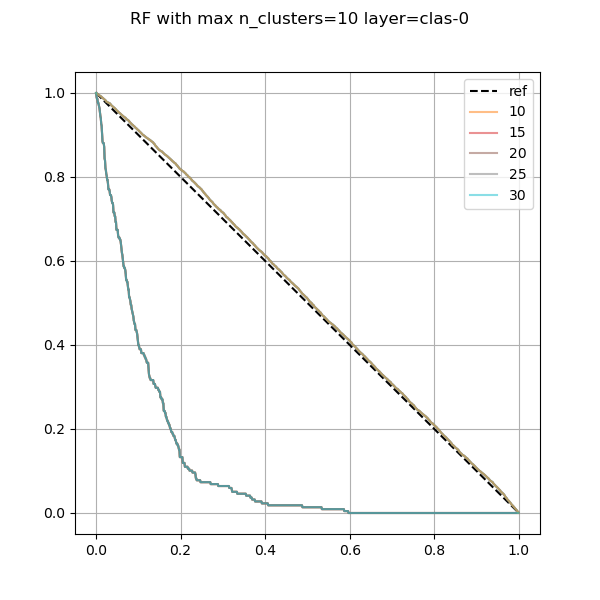

Error in callback <function flush_figures at 0x7f8dfb508a60> (for post_execute):



KeyboardInterrupt



In [ ]:
for j, (layer, weight) in enumerate(w_dict.items()):

    for n in num_clusters:    
        
        fig, axs = plt.subplots(1, figsize=(6, 6))
        axs.grid()
        axs.plot([0, 1],[1,0],label='ref', c='k', ls='--')
        
        for dim in dims_list: 
            
            prob_train = out_p_prob_train[layer][(dim, n)]
            prob_val = out_p_prob_val[layer][(dim, n)]
            
            if measure=='max':
                conf_t = np.max(prob_train,axis=1)
                conf_v = np.max(prob_val,axis=1)
            elif measure=='entropy':
                conf_t = H(prob_train,axis=1)
                conf_v = H(prob_val,axis=1)
            
            threshold = []
            list_true_max_ = []
            list_false_max_ = []
            
            for i in array:
            
                perc = np.quantile(conf_t, i)
                
                threshold.append(perc)
                idx = np.argwhere(conf_v>perc)[:,0]
                counter = collections.Counter(results_v[idx])
                list_true_max_.append(counter[True]/tot_true_v)
                list_false_max_.append(counter[False]/tot_false_v)  

            axs.plot(array, list_true_max_, alpha=0.5)
            axs.plot(array, list_false_max_, label=f'{dim}', alpha=0.5)
            
            axs.legend()
            fig.suptitle(f'RF with {measure} n_clusters={n} layer={layer}\n', fontsize=12)
            # axs[j].set_title(f'weights={formatted_weight}')
            #axs[j,k].title(f'dim={dim} num_clusters={n}', fontsize=16)
            
            
fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [458]:
val, idx = torch.topk(cs, 5, axis=1)

In [459]:
idx[:, 1]

tensor([85, 29, 92,  ..., 76, 91, 86])

In [460]:
(v_labels['train']).to(int)

tensor([85,  9, 14,  ..., 56, 55, 39])

In [461]:
torch.sum((v_labels['train']).to(int)==torch.argmax(cs, axis=1))

tensor(1694)

In [462]:
torch.sum((v_labels['train']).to(int)==idx[:, 1])

tensor(1117)

## Testing with memmap


In [1]:
import os
import json
import torch
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from peepholes.peepholes import Peepholes
from clustering.clustering import Clustering
from clustering.clustering import prepare_data, compute_scores

In [82]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

#--------------------------------
# Parameters
#--------------------------------
dnn_model = 'vgg16'
abs_path = '/srv/newpenny/XAI/generated_data'
dataset = 'CIFAR100' 
seed = 29
bs = 64
ds = Cifar(dataset=dataset)

ds.load_data(batch_size=bs, data_kwargs={'num_workers': 4, 'pin_memory': True}, seed=seed) 
print('Loading the ex-peepholes')

phs_name = 'peepholes'
phs_dir = os.path.join(abs_path, 'peepholes')
peepholes = Peepholes(path=phs_dir, name=phs_name)
loaders = ds.get_dataset_loaders()

# Copy dataset to peepholes dataset
peepholes.get_peep_dataset(loaders=loaders, verbose=True) 
ph_dl = peepholes.get_dataloaders(batch_size=128, verbose=True)

available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())

Using cuda:6 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified
Loading the ex-peepholes

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.test exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test


In [91]:
print('Computing confidence scores')

k_list = [20, 50, 70]
n_clusters_list = [50, 100, 150, 200]
layers_list = available_layers
algorithm = 'gmm'

# check for existing results or init results container
res_dir = 'clustering/confidence_scores'
res_path = os.path.join(abs_path, res_dir)
tensor_dict_path = os.path.join(res_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(tensor_dict_path):
    print('Results already present')
    all_scores = TensorDict.load_memmap(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

Computing confidence scores
Results already present


In [4]:
# converting my old data to memmap

# Ensure the results directory exists
res_dir = 'clustering/confidence_scores'
res_path = os.path.join('/srv/newpenny/XAI/generated_data', res_dir)

if not os.path.exists(res_path):
    os.makedirs(res_path)

# Loading existing scores from .pth file if needed
old_tensor_dict_path = os.path.join(res_path, 'algorithm=gmm_dataset=CIFAR100_dnn=vgg16.pth')

# Check if the file exists
if os.path.exists(old_tensor_dict_path):
    # Load existing all_scores
    all_scores = torch.load(old_tensor_dict_path)

    # Create a new MemoryMappedTensor with the same structure
    new_all_scores = TensorDict({}, batch_size=[])

    for k in all_scores.keys():
        new_all_scores.set(str(k), TensorDict({}, batch_size=[]))
        for n_clusters in all_scores[str(k)].keys():
            new_all_scores[str(k)].set(str(n_clusters), TensorDict({}, batch_size=[]))
            for split in all_scores[str(k)][str(n_clusters)].keys():
                new_all_scores[str(k)][str(n_clusters)].set(split, TensorDict({}, batch_size=[]))
                for layer in all_scores[str(k)][str(n_clusters)][split].keys():
                    # Create MemoryMappedTensor for max and entropy
                    _max = all_scores[str(k)][str(n_clusters)][split][layer]['max']
                    _entropy = all_scores[str(k)][str(n_clusters)][split][layer]['entropy']

                    new_all_scores[str(k)][str(n_clusters)][split][layer] = {
                        'max': MMT(_max.shape),
                        'entropy': MMT(_entropy.shape)
                    }
                    # Populate the MMT with existing data
                    new_all_scores[str(k)][str(n_clusters)][split][layer]['max'].copy_(_max)
                    new_all_scores[str(k)][str(n_clusters)][split][layer]['entropy'].copy_(_entropy)

    # Save the new MemoryMappedTensor
    new_tensor_dict_path = os.path.join(res_path, 'algorithm=gmm_dataset=CIFAR100_dnn=vgg16.memmap')
    new_all_scores.memmap(new_tensor_dict_path, num_threads=4)

    print(f"Converted and saved new all_scores with memory mapping at {new_tensor_dict_path}.")
else:
    print(f"No existing scores found at {old_tensor_dict_path}. Please check the path.")


/tmp/ipykernel_1356887/2924401518.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_scores = torch.load(old_tensor_dict_path)


Converted and saved new all_scores with memory mapping at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/algorithm=gmm_dataset=CIFAR100_dnn=vgg16.memmap.


In [92]:
# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

New peepholes results already present


In [85]:
peephole_scores

TensorDict(
    fields={
        20: TensorDict(
            fields={
                100: TensorDict(
                    fields={
                        train: TensorDict(
                            fields={
                                classifier.0: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                classifier.3: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.24: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.26: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.28: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True)},
                            batch_size=torch.Size([]),


In [ ]:
# Loop over k and n_clusters
for k in k_list:
    str_k = str(k)
    if str_k not in all_scores.keys():
        all_scores.set(str_k, TensorDict({}, batch_size=[]))
    
    for n_clusters in n_clusters_list:
        str_n_clusters = str(n_clusters)

        # Check if the combination of k and n_clusters already exists in the scores
        if str_n_clusters in all_scores[str_k].keys():
            existing_layers = all_scores[str_k][str_n_clusters]['train'].keys()
            
            # Compute only the missing layers
            for layer in layers_list:
                if layer not in existing_layers:
                    data = prepare_data(ph_dl, [layer], k)
                    print(f'Clustering for layer={layer}')
                    compute_scores(k, n_clusters, algorithm, [layer], data, all_scores, metadata)
        else:
            print(f'Clustering with algorithm={algorithm}, k={k}, n_clusters={n_clusters}')
            # If not existing, create the subdict for n_clusters
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[])
            }, batch_size=[]))
            
            # Prepare data for all splits
            data = prepare_data(ph_dl, layers_list, k)
            compute_scores(k, n_clusters, algorithm, layers_list, data, all_scores, metadata)

# Pre-allocate memory-mapped tensors for scores
for layer in layers_list:
    n_samples = len(loaders['train'].dataset)  # Get the number of samples from the training loader
    all_scores[str_k][str_n_clusters]['train'][layer] = MMT.empty(shape=torch.Size((n_samples,)))  # Initialize with MMT

# Save all scores and metadata after processing
all_scores.memmap(tensor_dict_path, num_threads=4)  # Specify the number of threads for saving
with open(meta_path, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print('Results and metadata saved.')

In [86]:
peephole_scores[str(k)][str(n_clusters)][split]['features.24']

MemoryMappedTensor([[1.4297e-02, 6.2320e-03, 8.3093e-03,  ..., 2.0773e-03,
                     4.1895e-03, 4.0850e-03],
                    [9.1433e-03, 1.1254e-02, 1.6600e-02,  ..., 5.3462e-03,
                     2.2934e-02, 5.3461e-03],
                    [1.4275e-02, 6.1651e-03, 8.2201e-03,  ..., 2.0550e-03,
                     4.1258e-03, 4.0786e-03],
                    ...,
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     2.1116e-15, 1.4074e-15],
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     1.0332e-35, 6.9172e-36],
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     3.3153e-22, 1.2134e-22]])

In [87]:
torch.max(peephole_scores[str(k)][str(n_clusters)][split]['classifier.3'], axis=1)

torch.return_types.max(
values=tensor([0.0470, 0.0470, 0.0321,  ..., 0.1230, 0.0325, 0.0252]),
indices=tensor([95, 95, 73,  ..., 21,  4, 88]))

In [88]:
data['true_labels']['val']

tensor([44., 18., 83.,  ..., 44., 42., 45.])

In [89]:
c = data['true_labels']['val']
_, g = torch.max(peephole_scores[str(50)][str(150)][split]['classifier.0'], axis=1)

In [90]:
torch.sum(c == g)

tensor(4975)

In [40]:
for k in k_list:  # loop over core-vector dimension
    str_k = str(k)

    # initialize peephole_scores for k
    if str_k not in peephole_scores.keys():
        peephole_scores.set(str_k, TensorDict({}, batch_size=[]))

    for n_clusters in n_clusters_list:  # loop over n_clusters
        str_n_clusters = str(n_clusters)

        # initialize peephole_scores for n_clusters
        if str_n_clusters not in peephole_scores[str_k].keys():
            peephole_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[]),
            }, batch_size=[]))

        # for both train and val splits, ensure layers exist
        for split in ['train', 'val']:
            if split not in peephole_scores[str_k][str_n_clusters].keys():
                peephole_scores[str_k][str_n_clusters].set(split, TensorDict({}, batch_size=[]))

            existing_layers = peephole_scores[str_k][str_n_clusters][split].keys()
            
            # check if all layers are present in the current split
            if existing_layers and any(layer not in existing_layers for layer in layers_list):
                for layer in layers_list:
                    if layer not in existing_layers:
                        data = prepare_data(ph_dl, [layer], k)
                        print(f'Clustering for layer={layer} with n_clusters={n_clusters}')
                        compute_scores(k, 
                                       n_clusters, 
                                       algorithm, 
                                       [layer], 
                                       data, 
                                       peephole_scores, 
                                       all_scores, 
                                       compute_scores=True, 
                                       seed=42)

            else:
                print(f'Skipping {algorithm} k={k}, n_clusters={n_clusters} for {split} layers')
                continue  # skip to the next n_clusters if all layers have data

        # if not all layers have data, we still need to compute scores
        if str_n_clusters not in peephole_scores[str_k].keys() or not existing_layers:
            print('Clustering')
            print(f'algorithm={algorithm}, k={k}, n_clusters={n_clusters}')

            data = prepare_data(ph_dl, layers_list, k)

            n_samples_train = len(data['core_vectors']['train'][layers_list[0]])
            n_samples_val = len(data['core_vectors']['val'][layers_list[0]])

            # initialize all_scores for n_clusters
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({
                    layer: MMT.empty(shape=(n_samples_train,)) for layer in layers_list}, batch_size=[]),
                'val': TensorDict({
                    layer: MMT.empty(shape=(n_samples_val,)) for layer in layers_list}, batch_size=[])
            }, batch_size=[]))

            compute_scores(k, 
                           n_clusters, 
                           algorithm, 
                           layers_list, 
                           data, 
                           peephole_scores, 
                           all_scores, 
                           compute_scores=True, 
                           seed=42)

# save results
peephole_scores.memmap(new_peep_tensor_dict_path, num_threads=4)
all_scores.memmap(tensor_dict_path, num_threads=4)
print('Results saved to memory-mapped tensor.')


Skipping gmm k=20, n_clusters=100 for train layers
Skipping gmm k=20, n_clusters=100 for val layers
Clustering
algorithm=gmm, k=20, n_clusters=100
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=20, n_clusters=100 with RNG seed=42
Skipping gmm k=20, n_clusters=150 for train layers
Skipping gmm k=20, n_clusters=150 for val layers
Clustering
algorithm=gmm, k=20, n_clusters=150
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=20, n_clusters=150 with RNG seed=42
Skipping gmm k=50, n_clusters=100 for train layers
Skipping gmm k=50, n_clusters=100 for val layers
Clustering
algorithm=gmm, k=50, n_clusters=100
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=50, n_clusters=100 with RNG seed=42
Skipping gmm k=50, n_clusters=150 for train layers
Skipping gmm k=50, n_clusters=150 for val layers
Clustering
algorithm=gmm, k=50, n_clusters=150
Preparing data
P

In [19]:
layer_dict = TensorDict({layer: MMT.empty(shape=(n_samples, n_classes)) for layer in layers_list}, batch_size=[])

peephole_scores[str(k)].set(str(n_clusters), TensorDict({
    split: layer_dict  # Pre-allocate memory-mapped tensor for each layer
}, batch_size=[]))

TensorDict(
    fields={
        20: TensorDict(
            fields={
            },
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        50: TensorDict(
            fields={
            },
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

# stuff with coreVectors

In [2]:
# python stuff
from pathlib import Path as Path
from numpy.random import randint

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn

In [6]:

use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

#--------------------------------
# Dataset 
#--------------------------------
# model parameters
dataset = 'CIFAR100' 
seed = 29
bs = 64

ds = Cifar(
        data_path = 'srv/newpenny/dataset/CIFAR100',
        dataset=dataset
        )
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

ds = Cifar(dataset=dataset)

ds.load_data(batch_size=bs, data_kwargs={'num_workers': 4, 'pin_memory': True}, seed=seed) 
print('Loading the "ex"-peepholes')

phs_name = 'peepholes'
phs_dir = os.path.join(abs_path, 'peepholes')
peepholes = Peepholes(path=phs_dir, name=phs_name)
loaders = ds.get_dataset_loaders()

# Copy dataset to peepholes dataset
peepholes.get_peep_dataset(loaders=loaders, verbose=False) 
ph_dl = peepholes.get_dataloaders(batch_size=128, verbose=False)

available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())

Using cuda:6 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified

 ---- Getting data from train

loader n_samples:  40000
Copying images and labels


 11%|████▋                                     | 70/625 [00:05<00:47, 11.80it/s]


KeyboardInterrupt: 

In [7]:
phs_dir

PosixPath('/srv/newpenny/XAI/generated_data/corevectors')

In [3]:
phs_name = 'corevectors'
abs_data_path = '/srv/newpenny/XAI/generated_data'
phs_dir = Path(abs_data_path).joinpath(phs_name)
phs_dir

PosixPath('/srv/newpenny/XAI/generated_data/corevectors')